In [168]:
import torch
import numpy as np
import datasets
import os
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from datasets import Dataset, DatasetDict
from torch import nn
from sentence_transformers import SentenceTransformer
from nltk import sent_tokenize
from IPython.core.debugger import Pdb
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from transformers import AutoModel, AutoTokenizer
import umap

datasets.disable_caching()

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Datasets

In [4]:
allsides_dir = '/data/john/projects/llm_eval/data/all_sides/test.json'
ppp_dir = '/data/john/projects/llm_eval/data/privacy_policy/3p_data.csv'

ds = DatasetDict({
    'allsides': Dataset.from_json(allsides_dir),
    'ppp': Dataset.from_csv(ppp_dir),
})
print(ds)

Generating train split: 137 examples [00:00, 5611.68 examples/s]

DatasetDict({
    allsides: Dataset({
        features: ['Key', 'Left', 'Right', 'Ahmed_Intersection', 'Naman_Intersection', 'Helen_Intersection', 'AllSides_Intersection'],
        num_rows: 137
    })
    ppp: Dataset({
        features: ['Company_1', 'Company_2', 'Category', 'Company_Name_1', 'Company_Name_2', 'Company_Len_1', 'Company_Len_2', 'Annotator1', 'Annotator2', 'Annotator3', 'Unnamed: 10'],
        num_rows: 135
    })
})


# Make Dict of Relevant Column Names

In [14]:
cols = {
    'allsides': ['Left',
                 'Right',
                 'Ahmed_Intersection',
                 'Naman_Intersection',
                 'Helen_Intersection',
                 'AllSides_Intersection',],
    'ppp': ['Company_1',
            'Company_2',
            'Annotator1',
            'Annotator2',
            'Annotator3']
}

# Set Sentence Transformer Models

In [8]:
sent_models = [
    'all-mpnet-base-v2',
    'multi-qa-mpnet-base-dot-v1',
    'all-distilroberta-v1',
    'all-MiniLM-L12-v2',
    'multi-qa-distilbert-cos-v1',
    'all-MiniLM-L6-v2',
    'multi-qa-MiniLM-L6-cos-v1',
    'paraphrase-multilingual-mpnet-base-v2',
    'paraphrase-albert-small-v2',
    'paraphrase-multilingual-MiniLM-L12-v2',
    'paraphrase-MiniLM-L3-v2',
    'distiluse-base-multilingual-cased-v1',
    'distiluse-base-multilingual-cased-v2',
]

# Select Model and Plot Sentences

In [28]:
device='cuda:1'

def map_fn(sample, **fn_kwargs):
    cols = fn_kwargs['cols']
    model = fn_kwargs['model']
    for col in cols:
        sample[col + '-embeds'] = model.encode(sample[col])
        sample[col + '-sents'] = sent_tokenize(sample[col])
        sample[col + '-sent_lengths'] = len(sample[col + '-sents'])
        sample[col + '-sent_embeds'] = model.encode(sample[col + '-sents'], convert_to_numpy=True)
    return sample

data = {}
for model_name in sent_models:
    model = SentenceTransformer(sent_models[0], cache_folder='./cache')
    model = model.to(device)
    for key in ds.keys():
        data[model_name + '-' + key] = ds[key].map(
            map_fn, 
            fn_kwargs={'cols': cols[key],
                       'model': model},
        )

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:17<00:00,  7.68 examples/s]


# Plot AllSides Vs. PPP

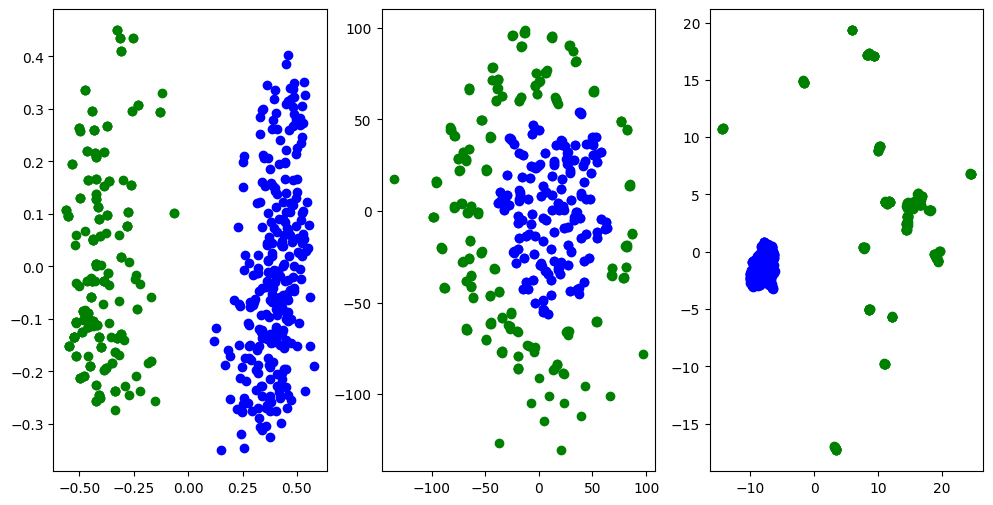

In [93]:
model_name = 'all-mpnet-base-v2'
d1 = data[model_name + '-allsides'].with_format('numpy')
d2 = data[model_name + '-ppp'].with_format('numpy')
#cutoff = d['Left-embeds'].shape[0]

X1 = np.vstack((d1['Left-embeds'], d1['Right-embeds']))
X2 = np.vstack((d2['Company_1-embeds'], d2['Company_2-embeds']))
cutoff = X1.shape[0]

X = np.vstack((X1, X2))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
X_umap = umap.UMAP().fit_transform(X)

sample = 20
#X_pca[[0, sample]] = X_pca[[sample, 0]]
#X_pca[[1, sample+cutoff]] = X_pca[[sample+cutoff, 1]]
#print(X_pca[:2])
#plt.scatter(*X_pca[2:].T, color='green')
#plt.scatter(*X_pca[:2].T, color='blue')
fig, ax = plt.subplots(ncols=3, figsize=(12, 6))

# Plot PCA
ax[0].scatter(*X_pca[cutoff:].T, color='green')
ax[0].scatter(*X_pca[:cutoff].T, color='blue')

# Plot tSNE
ax[1].scatter(*X_tsne[cutoff:].T, color='green')
ax[1].scatter(*X_tsne[:cutoff].T, color='blue')

# Plot UMAP
ax[2].scatter(*X_umap[cutoff:].T, color='green')
ax[2].scatter(*X_umap[:cutoff].T, color='blue')

# Save Embeddings to Dataset

In [175]:

params = product(ds.keys(), sent_models)
embeddings = []
sample_ids = []
sample_col_names = []
embedding_types = []
ds_names = []
model_names = []
for ds_name, model in params:
    for i, sample in enumerate(data[model + '-' + ds_name]):
        for col in cols[ds_name]:
            
            # get sentence embeddings and corresponding document embedding (doc_emb goes from (d_embedding,) to (1, d_embedding))
            sent_embs = np.array(sample[col + '-sent_embeds'])
            doc_emb = np.array(sample[col + '-embeds'])[None]

            len_sent_embs = len(sent_embs)
            len_total = len_sent_embs + 1
            
            embeddings.append(sent_embs)
            embeddings.append(doc_emb)
            
            sample_col_names += [col]*len_total

            sample_ids += [i]*len_total
            embedding_types += ['sentence']*len_sent_embs + ['document']
            ds_names += [ds_name]*len_total
            model_names += [model]*len_total

embeddings = np.vstack(embeddings)

emb_ds = Dataset.from_dict({
    'embedding': embeddings,
    'sample_id': sample_ids,
    'sample_col_name': sample_col_names,
    'embedding_type': embedding_types,
    'ds_name': ds_names,
    'model': model_names,
})

trgt_dir = './data'
if not os.path.exists(trgt_dir):
    Path(trgt_dir).mkdir(parents=True, exist_ok=True)
emb_ds.to_parquet(trgt_dir + '/emb_ds.parquet')

Creating parquet from Arrow format: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 30.91ba/s]


860241381

# Make Plot for Each Sample

In [188]:
ds_dir = './data/'
ds_path = ds_dir + '/emb_ds.parquet'
emb_ds = Dataset.from_parquet(ds_path).with_format('numpy')
num_samples = len(ds['allsides']) + len(ds['ppp'])

trgt_dir = './data/scatter/'

granularity = ['sentence', 'document']
params = product(ds.keys(), sent_models, methods)
for ds_name, model_name, gran in params:
    trgt_data = emb_ds.filter(
        lambda x: x['ds_name'] == ds_name 
                  and x['model'] == model_name
                  and x['embedding_type'] == gran 
    )
    
    embeddings = trgt_data['embedding']
    
    pca_embs = PCA(n_components=2).fit_transform(embeddings)
    tsne_embs = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(embeddings)
    umap_embs = umap.UMAP().fit_transform(embeddings)
    emb_dict = {
        'pca': pca_embs,
        'tsne': tsne_embs,
        'umap': umap_embs,
    }

    
    for i in range(len(ds[ds_name])):
        sample_rows = [idx for idx in range(len(trgt_data)) if trgt_data[idx]['sample_id'] == i]
        non_sample_rows = list(set(range(len(trgt_data))) - set(sample_rows))

        if ds_name == 'allsides':
            d1_idx = [row for row in sample_rows if trgt_data[row]['sample_col_name'] == 'Left']
            d2_idx = [row for row in sample_rows if trgt_data[row]['sample_col_name'] == 'Right']
            labels = ['Left' , 'Right']
        else:
            d1_idx = [row for row in sample_rows if trgt_data[row]['sample_col_name'] == 'Company_1']
            d2_idx = [row for row in sample_rows if trgt_data[row]['sample_col_name'] == 'Company_2']
            labels = ['Company_1', 'Company_2']
        other_idx = list(set(sample_rows) - set(d1_idx + d2_idx))

        # plot
        fig, ax = plt.subplots(ncols=3, figsize=(12,6))
        for j, (method, emb) in enumerate(emb_dict.items()):
            ax[j].scatter(*emb[non_sample_rows].T)
            ax[j].scatter(*emb[d1_idx].T)
            ax[j].scatter(*emb[d2_idx].T)
            ax[j].scatter(*emb[other_idx].T)
            ax[j].set_title(method)
            
        labels = ['All Data'] + labels + ['References']
        plt.figlegend(labels, loc='upper left')
        fig.suptitle(f'{gran.title()} Level Embeddings')

        # save figure
        trgt_dir= f'./data/scatter/{ds_name}/{model_name}/{gran}/'
        if not os.path.exists(trgt_dir):
            Path(trgt_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(f'{trgt_dir}/sample{i:02}.png')

        #labels = sample_rows['
        
        sample_data = trgt_data.select(sample_rows)
plt.close("all")
        

Filter: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138281/138281 [00:00<00:00, 171524.18 examples/s]
/tmp/ipykernel_2048596/1343144110.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(ncols=3, figsize=(12,6))
Filter: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138281/138281 [00:01<00:00, 83923.98 examples/s]


# See How Much Text Gets Truncated When Encoding

In [108]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
max_length=512
text = ds['ppp'][0]['Company_1']

tokens = tokenizer(
    text,
    truncation=True,
    max_length=max_length,
    return_tensors='pt',
)
decoded_text = tokenizer.batch_decode(tokens['input_ids'], skip_special_tokens=True)[0]


print(tokens['input_ids'].shape)
print(text, end='\n\n')
print(len(text), len(decoded_text))
print(len(text.split()), len(decoded_text.split()))
print(len(sent_tokenize(text)))


torch.Size([1, 512])


Amazon.com knows that you care how information about you is used and shared, and we appreciate your trust that we will do so carefully and sensibly. This notice describes our privacy policy. By visiting Amazon.com, you are accepting the practices described in this Privacy Notice. What Personal Information About Customers Does Amazon.com Gather? What About Cookies? Does Amazon.com Share the Information It Receives? How Secure Is Information About Me? What About Third-Party Advertisers and Links to Other Websites? Which Information Can I Access? What Choices Do I Have? Are Children Allowed to Use Amazon.com? Does Amazon.com Participate in the Safe Harbor Program? Conditions of Use, Notices, and Revisions Examples of Information Collected 

 How Secure Is Information About Me? We work to protect the security of your information during transmission by using Secure Sockets Layer (SSL) software, which encrypts information you input. We reveal only the last four digits 